# Session 3:  Cloud Computing
## Learning Objectives
## S3 objects
intro here - explain special module and functio we will use and special nature of scedc index files

In [1]:
import scedc_s3 as scedc
catalog_index=scedc.get_s3_index_keys("catalog")
wf_index=scedc.get_s3_index_keys("wf")
print("Number of keys in catalog index=",len(catalog_index))
print("Number of keys in waveform index=",len(wf_index))

Number of keys in catalog index= 198
Number of keys in waveform index= 18905


As you can see there are a lot of items in those two indices.   Let's look at what a typical example of both:

In [2]:
print("First entry in catalog index=",catalog_index[0])
print("First entry in waveform index=",wf_index[0])

First entry in catalog index= earthquake_catalogs/index/csv/year=1932/1932_catalog_index.csv
First entry in waveform index= continuous_waveforms/index/csv/year=1999/year_doy=1999_169/1999_169_waveform_index.csv


blah blah

example of using mongodb to manage special information in a peculiar format

convert examples to documents with these two functions to show what they do

In [3]:
from  mspasspy.util.seismic import print_metadata
catidoc=scedc.catkey2doc(catalog_index[0])
wfidoc=scedc.wfkey2doc(wf_index[0])
print("Catalog index key converted to a dictionary for MongoDB")
print_metadata(catidoc)
print("Waveform index key converted to a dictionary for MongoDB")
print_metadata(wfidoc)

Catalog index key converted to a dictionary for MongoDB
{
  "s3key": "earthquake_catalogs/index/csv/year=1932/1932_catalog_index.csv",
  "index_type": "earthquake_catalogs",
  "format": "csv",
  "year": 1932,
  "filename": "1932_catalog_index.csv"
}
Waveform index key converted to a dictionary for MongoDB
{
  "s3key": "continuous_waveforms/index/csv/year=1999/year_doy=1999_169/1999_169_waveform_index.csv",
  "index_type": "continuous_waveforms",
  "format": "csv",
  "year": 1999,
  "yrday": "1999_169",
  "day": 169,
  "filename": "1999_169_waveform_index.csv"
}


save all of the index keys to documents using those converts.

In [4]:
from mspasspy.db.database import Database
import mspasspy.client as msc
mspass_client = msc.Client()
dbname="scedc_s3"
db = mspass_client.get_database(dbname)

In [6]:
# put the two types of keys in two different collections - type example of appropriate grouping in a "collection"
catindex_collection="s3_catalog_index"
wfindex_collection="s3_waveform_index"
for k in catalog_index:
    doc = scedc.catkey2doc(k)
    db[catindex_collection].insert_one(doc)
for k in wf_index:
    doc = scedc.wfkey2doc(k)
    db[wfindex_collection].insert_one(doc)
n=db[catindex_collection].count_documents({})
print("Number of documents stored in {} collection={}".format(catindex_collection,n))
n=db[wfindex_collection].count_documents({})
print("Number of documents stored i {} collection={}".format(wfindex_collection,n))

Number of documents stored in s3_catalog_index collection=198
Number of documents stored i s3_waveform_index collection=18905


query a year and fetch the catalog for that year

In [8]:
# uses these two temporary variables as shorthand to reduce typing
catcol=db[catindex_collection]
wficol=db[wfindex_collection]

In [14]:
query={"year" : 2023,"format" : "parquet"}
n = catcol.count_documents(query)
if n!=1:
    raise RuntimeError("Something is wrong - that should be a unique match")
doc=catcol.find_one(query)
df = scedc.s3_index_reader(doc)
print("Index file retrieved from s3 and converted to pandas DataFrame")
print(df)

Index file retrieved from s3 and converted to pandas DataFrame
               PREFIX  MS_FILENAME  PHASE_FILENAME         ORIGIN_DATETIME  \
0      2023/2023_001/  40152455.ms  40152455.phase 2023-01-01 00:32:22.630   
1      2023/2023_001/  40152463.ms  40152463.phase 2023-01-01 00:57:36.510   
2      2023/2023_001/  40152471.ms  40152471.phase 2023-01-01 01:00:24.860   
3      2023/2023_001/  40152479.ms  40152479.phase 2023-01-01 01:07:57.960   
4      2023/2023_001/  40152487.ms  40152487.phase 2023-01-01 02:10:25.560   
...               ...          ...             ...                     ...   
13613  2023/2023_365/           NA              NA 2023-12-31 03:52:46.060   
13614  2023/2023_365/           NA              NA 2023-12-31 06:38:55.200   
13615  2023/2023_365/           NA              NA 2023-12-31 07:22:22.890   
13616  2023/2023_365/           NA              NA 2023-12-31 07:42:00.790   
13617  2023/2023_365/           NA              NA 2023-12-31 07:49:05.770   



text should note that dataframes are stock tools of "big data" and have a rich api that simulate database operations.  At this stage you could save these data to MongoDB or just use the pandas api.  For this tutorial we will do the later.   might also note parallel processing could be driven by subset of this dataframe for event based processing.   There are dask map operations that loop over the dataframe - may actually want to do that.  

Subset events over a mag threshold


In [18]:
df_big = df.loc[df['MAG'] > 4.5]
print(df_big)

               PREFIX  MS_FILENAME  PHASE_FILENAME         ORIGIN_DATETIME  \
8832   2023/2023_232/  39645386.ms  39645386.phase 2023-08-20 21:41:00.970   
12470  2023/2023_335/  39720706.ms  39720706.phase 2023-12-01 07:43:27.480   

       ET GT   MAG  M     LAT      LON  DEPTH  Q      EVID  NPH  NGRM  
8832   eq  l  5.08  w  34.408 -119.188    4.8  A  39645386  214  3502  
12470  eq  l  4.80  w  32.752 -115.873    8.7  A  39720706  168  3407  


Fetch data from biggest event from 2023 and store the file

Do as a hand job this time so students can see under the hood a bit

In [22]:
import obspy 
import io
import boto3
from botocore import UNSIGNED
from botocore.config import Config
s3client = boto3.client('s3',config=Config(signature_version=UNSIGNED))
# can be created in a program by combining PREFIX and MS_FILENAME
s3key="event_waveforms/2023/2023_232/39645386.ms"
obj = s3client.get_object(Bucket="scedc-pds",Key=s3key)
mseed_content=obj["Body"].read()
st = obspy.read(io.BytesIO(mseed_content),format="mseed")
print(st)

4450 Trace(s) in Stream:

AZ.CRY..BHE | 2023-08-20T21:40:57.119500Z - 2023-08-20T21:47:14.169500Z | 40.0 Hz, 15083 samples
...
(4448 other traces)
...
WR.CSP..HNZ | 2023-08-20T21:40:52.150000Z - 2023-08-20T21:46:58.490000Z | 100.0 Hz, 36635 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


convert to mspass data object and plot a portion

In [23]:
from mspasspy.util.converter import Stream2TimeSeriesEnsemble
ensemble=Stream2TimeSeriesEnsemble(st)

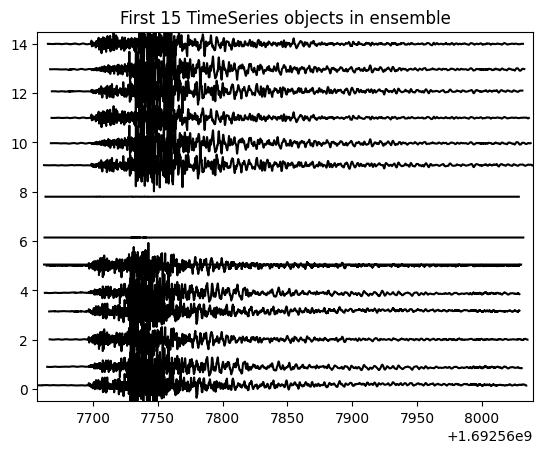

In [29]:
from mspasspy.graphics import SeismicPlotter
from mspasspy.ccore.seismic import TimeSeriesEnsemble
plotter = SeismicPlotter(normalize=True)
# these are just to improve the plot
plotter.style="wt"
plotter.title="First 15 TimeSeries objects in ensemble"
e2plot=TimeSeriesEnsemble(15)
for i in range(15):
    e2plot.member.append(ensemble.member[i])
e2plot.set_live()
plotter.plot(e2plot)

text should then move a discussion of what one might do next with that capability?  

what are issue?  

How to parallelize event processing with that model?

How to add source and receiver metadata to do processing on data like that?  

note to self - exercises may ask questions for solutions to abvoe????

## Continuous data data 
Fetch a day index for Tohoku earthquake and retrieve 

In [30]:
from obspy import UTCDateTime
origin_time=UTCDateTime("2011-03-11T05:46:23.200000Z")
print("Event origin time=",origin_time)
# Define window range like test data as +100 s to +3700 s
tstart = origin_time.timestamp + 100.0
tend = origin_time.timestamp + 3700.0
print("Julian day of event=",origin_time.julday)

Event origin time= 2011-03-11T05:46:23.200000Z
Julian day of event= 70


In [33]:
from mspasspy.algorithms.window import WindowData
# fetch the index for 2011_070
collection="SCEDC_s3_index"
# type qualifier isn't needed because catalog data do not have year and day attributes
query={"year" : origin_time.year, "day" : origin_time.julday,"format" : "parquet"}
index_doc=db[wfindex_collection].find_one(query)
index_docs = scedc.make_day_index(index_doc)
print("Number of day files in index for this day=",len(index_docs))
# directory and file name where data are stored
dir="wf_TimeSeries/tohoku"
dfile="SCEDCwfdata.binary"
for doc in index_docs:
    ens = scedc.s3_mseed_reader(doc)
    if ens is not None:
        for d in ens.member:
            d["dir"]=dir
            d["dfile"]=dfile
            d["storage_mode"]="file"
            d = WindowData(d,tstart,tend)
            db.save_data(d,collection="wf_TimeSeries",storage_mode="file")
    

Number of day files in index for this day= 1751
Warning - file was segmented
Number of segments= 2
Warning - file was segmented
Number of segments= 2
Warning - file was segmented
Number of segments= 2
Error fetching data with s3 key= continuous_waveforms/2011/2011_070/BCCBX__HHE___2011070.ms
The s3 client say the specified object does not exist.
Error fetching data with s3 key= continuous_waveforms/2011/2011_070/BCCBX__HHN___2011070.ms
The s3 client say the specified object does not exist.
Error fetching data with s3 key= continuous_waveforms/2011/2011_070/BCCBX__HHZ___2011070.ms
The s3 client say the specified object does not exist.
Error fetching data with s3 key= continuous_waveforms/2011/2011_070/BCSPX__HHE___2011070.ms
The s3 client say the specified object does not exist.
Error fetching data with s3 key= continuous_waveforms/2011/2011_070/BCSPX__HHN___2011070.ms
The s3 client say the specified object does not exist.
Error fetching data with s3 key= continuous_waveforms/2011/2011_

In [34]:
print("Number of TimeSeries data saved=",db.wf_TimeSeries.count_documents({}))

Number of TimeSeries data saved= 1715


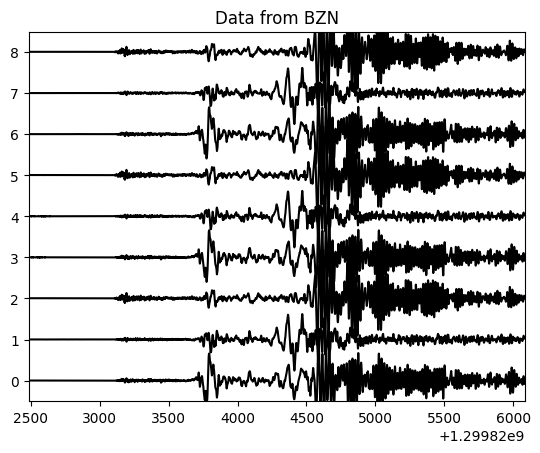

In [39]:
query={"sta" : "BZN"}  # first station in the file - random choice
cursor=db.wf_TimeSeries.find(query)
e = db.read_data(cursor,collection="wf_TimeSeries")
plotter.title="Data from BZN"
plotter.plot(e)